# Eight schools data - JAGS

#### Josep Fortiana 2018-12-19

SAT Example: Example from Chapter 5 of BDA3, pp. 119-124. Also, we reproduce (part of) [Aki Vehtari's tutorial](https://github.com/avehtari/BDA_R_demos/tree/master/demos_ch5).

We illustrate the hierarchical normal model with a problem in which the Bayesian analysis gives conclusions that differ in important respects from other methods. A study was performed for the Educational Testing Service to analyze the effects of special coaching programs on test scores. Separate randomized experiments were performed to estimate the effects of coaching programs for the SAT-V (Scholastic Aptitude Test-Verbal) in each of eight high schools. 
	
The outcome variable in each study was the score on a special administration of the SAT-V, a standardized multiple choice test administered by the Educational Testing Service and used to help colleges make admissions decisions; the scores can vary between 200 and 800, with mean about 500 and standard deviation about 100. The SAT examinations are designed to be resistant to short-term efforts directed specifically toward improving performance on the test; instead they are designed to reflect knowledge acquired and abilities developed over many years of education. Nevertheless, each of the eight schools in this study considered its short-term coaching program to be successful at increasing SAT scores. 

Also, there was no prior reason to believe that any of the eight programs was more effective than any other or that some were more similar in effect to each other than to any other.
  
The relevant question is: Do different SAT training programs have a positive effect on SAT scores?

The results of the experiments are summarized below: Observed effects of special preparation on SAT-V scores in eight randomized experiments for the eight schools $A,B,C,D,E,F,G,H$. Vector $y$ contains the estimated treatment effect
$y_{j}$ for each school, $\sigma$ contains the standard error $\sigma_{j}$ of each effect estimate. Estimates are based on separate analyses for the eight experiments.

All students in the experiments had already taken the PSAT (Preliminary SAT), and allowance was made for differences in the PSAT-M (Mathematics) and PSAT-V test scores between coached and uncoached students. In particular, in each school the estimated coaching effect and its standard error were obtained by an analysis of covariance adjustment (that is, a linear regression was performed of SAT-V on treatment group, using PSAT-M and PSAT-V as control variables) appropriate for a completely randomized experiment. A separate regression was estimated for each school. 

Although not simple sample means (because of the covariance adjustments), the estimated coaching effects, $y_{j}$ , and their sampling variances, $\sigma_{j}^{2}$, play the same role in our model as $\overline{y}_{\cdot j}$ and $\sigma^{2}_{j}$ in (Section 5.4 in the book).

The estimates $y_{j}$ are obtained by independent experiments and have approximately normal sampling distributions with sampling variances that are known, for all practical purposes, because the sample sizes in all of the eight e experiments were relatively large, over thirty students in each school (recall the discussion of data reduction in Section 4.1). Incidentally, an increase of eight points on the SAT-V corresponds to about one more test item correct.

## Data

In [2]:
J<-8
y<-c(28, 8,-3, 7,-1, 1,18,12)
s<-c(15,10,16,11, 9,11,10,18)

## Inferences based on nonhierarchical models and their problems

Before fitting the hierarchical Bayesian model, we first consider two simpler nonhierarchical
methods—estimating the effects from the eight experiments independently, and complete
pooling—and discuss why neither of these approaches is adequate for this example.

### Separate estimates

A cursory examination of Table 5.2 may at first suggest that some coaching programs have moderate effects (in the range 18–28 points), most have small effects (0–12 points), and two have small negative effects; however, when we take note
of the standard errors of these estimated effects, we see that it is difficult statistically to distinguish between any of the experiments. For example, treating each experiment separately and applying the simple normal analysis in each yields 95% posterior intervals that all overlap substantially.

In [3]:
#install.packages("ggplot2")
#install.packages("gridExtra")
#install.packages("tidyr")
require(ggplot2)
require(gridExtra)
require(tidyr)

Loading required package: ggplot2
Loading required package: gridExtra
Loading required package: tidyr


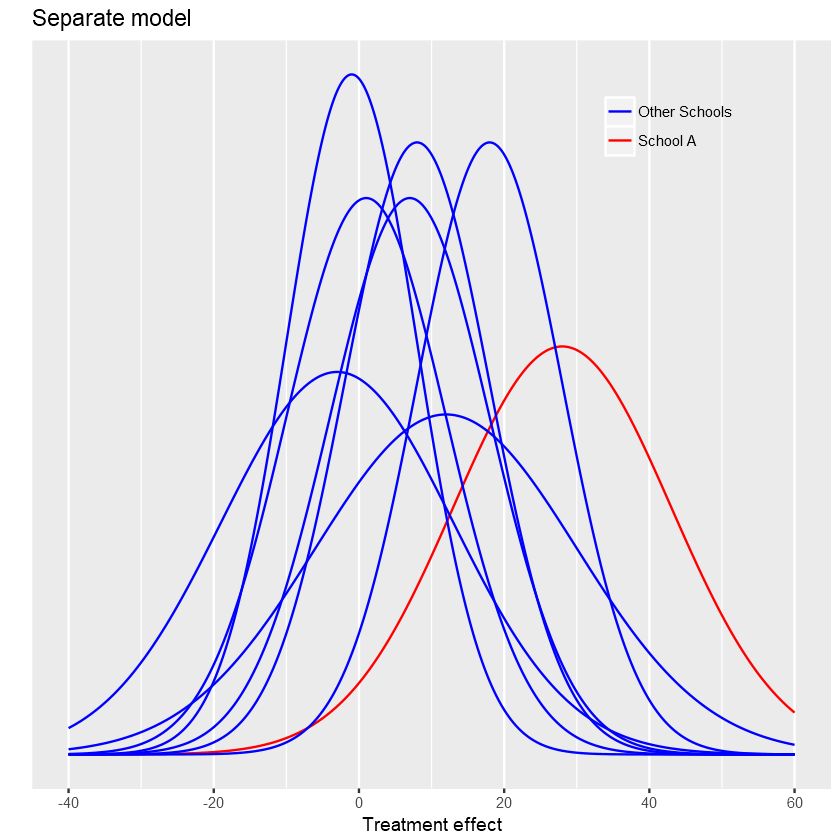

In [4]:
x <- seq(-40, 60, length.out = 500)
df_sep <- mapply(function(y, s, x) dnorm(x, y, s), y, s, MoreArgs = list(x = x)) %>%
  as.data.frame() %>% setNames(LETTERS[1:8]) %>% cbind(x) %>% gather(school, p, -x)
labs1 <- c('Other Schools', 'School A')
plot_sep <- ggplot(data = df_sep) +
  geom_line(aes(x = x, y = p, color = (school=='A'), group = school)) +
  labs(x = 'Treatment effect', y = '', title = 'Separate model', color = '') +
  scale_y_continuous(breaks = NULL) +
  scale_color_manual(values = c('blue','red'), labels = labs1) +
  theme(legend.background = element_blank(), legend.position = c(0.8,0.9))
#+ fig.height=4
plot_sep

### A pooled estimate. 

The general overlap in the posterior intervals based on independent
analyses suggests that all experiments might be estimating the same quantity. Under the 
hypothesis that all experiments have the same effect and produce independent estimates
of this common effect, we could treat the data in Table 5.2 as eight normally distributed
observations with known variances.

In [5]:
w<-1/s^2
y.dot.dot<-sum(w*y)/sum(w) # Formula (5.13) in BDA3
round(y.dot.dot,3)

[1] 7.686

In [6]:
# Posterior variance
round(1/sum(w),3)

[1] 16.581

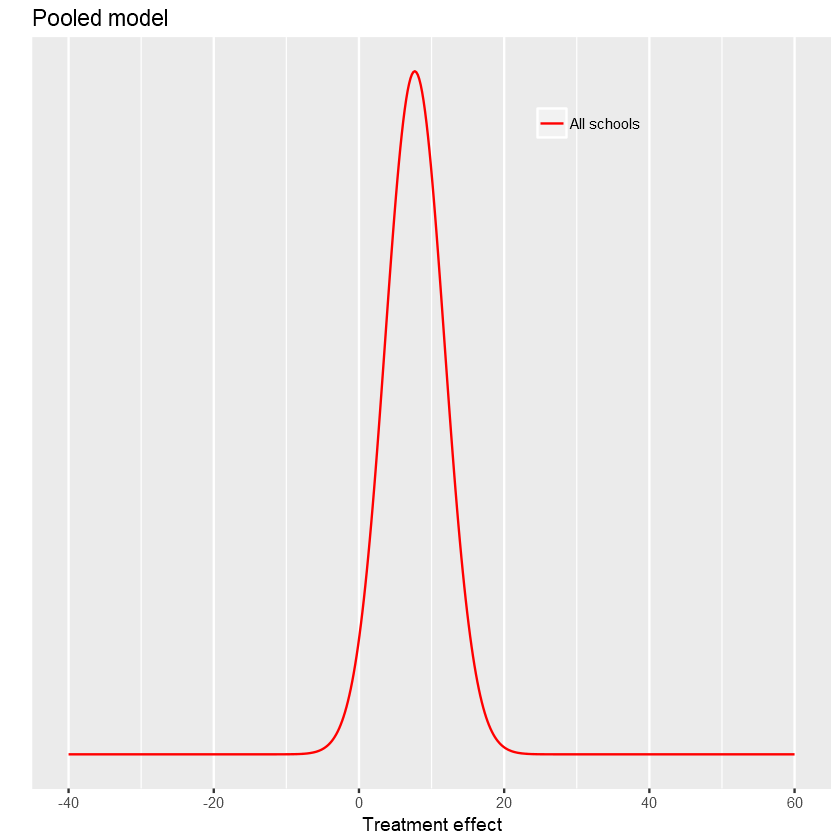

In [7]:
df_pool <- data.frame(x = x, p = dnorm(x, sum(y/s^2)/sum(1/s^2), sqrt(1/sum(1/s^2))))
#' Create plot for the pooled model
plot_pool <- ggplot(data = df_pool) +
  geom_line(aes(x = x, y = p, color = '1')) +
  labs(x = 'Treatment effect', y = '', title = 'Pooled model', color = '') +
  scale_y_continuous(breaks = NULL) +
  scale_color_manual(values = 'red', labels = 'All schools') +
  theme(legend.background = element_blank(), legend.position = c(0.7,0.9))
plot_pool

## Hierarchical model

In [8]:
#install.packages("R2jags", repos= "https://cloud.r-project.org")
#install.packages("lattice", repos= "https://cloud.r-project.org")
require(R2jags)

Loading required package: R2jags
Loading required package: rjags
Loading required package: coda
Linked to JAGS 4.3.0
Loaded modules: basemod,bugs

Attaching package: 'R2jags'

The following object is masked from 'package:coda':

    traceplot



### Specify model

Hierarchical multi-level model where the mean training effect `mu` is drawn from a noninformative mean zero normal distribution, with precision 1.0e-6, a school’s individual effect `theta[i]` is drawn from a normal distribution with with mean equal to `mu.theta` and precision `psi.theta`, and the observed scores `y[i]` are then drawn from a normal distribution with mean `theta[i]` and precision `psi.y[i]` (equal to `1/(s[i]^2)`). 

In [9]:
schools.data<-list(J = J,y = y,s = s)

In [10]:
schools.inits <- function()
  list (theta=rnorm(J,0,1), mu.theta=rnorm(1,0,100),tau=runif(1,0,100))

In [11]:
schools.model<-"
  model {
    for(i in 1:J){
        theta[i]~dnorm(mu.theta,psi.theta)
        psi.y[i]<-1/pow(s[i],2)
        y[i] ~ dnorm(theta[i],psi.y[i])
        }
  mu.theta ~ dnorm(0,1.0e-6)        
  psi.theta <- pow(tau, -2)     
  tau ~ dunif (0, 1000)   
}"
cat(schools.model,file="schools.model.jags")

### Run JAGS

In [12]:
schools.m1<-jags(data=schools.data,n.chains=3,parameters.to.save=c("theta", "mu.theta","tau"), 
        model.file="schools.model.jags",n.iter=10000,n.burnin=2000)

module glm loaded


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 8
   Unobserved stochastic nodes: 10
   Total graph size: 46

Initializing model



In [13]:
schools.m1.mcmc<-as.mcmc(schools.m1)
summary(schools.m1.mcmc)


Iterations = 2001:9993
Thinning interval = 8 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean    SD Naive SE Time-series SE
deviance 60.381 2.345  0.04281        0.05299
mu.theta  7.863 5.289  0.09656        0.15224
tau       6.644 6.015  0.10982        0.23474
theta[1] 11.355 8.513  0.15543        0.23077
theta[2]  7.848 6.344  0.11582        0.15868
theta[3]  6.230 7.684  0.14030        0.19599
theta[4]  7.644 6.666  0.12170        0.16432
theta[5]  5.244 6.395  0.11676        0.20276
theta[6]  6.052 6.745  0.12315        0.18048
theta[7] 10.331 6.699  0.12231        0.17416
theta[8]  8.225 7.970  0.14551        0.20026

2. Quantiles for each variable:

             2.5%    25%    50%    75% 97.5%
deviance  56.8338 58.941 59.974 61.399 66.26
mu.theta  -2.6889  4.638  8.064 11.088 17.65
tau        0.1798  2.508  5.179  8.904 22.87
theta[1]  -2.4000  5.931 10.362 15.43

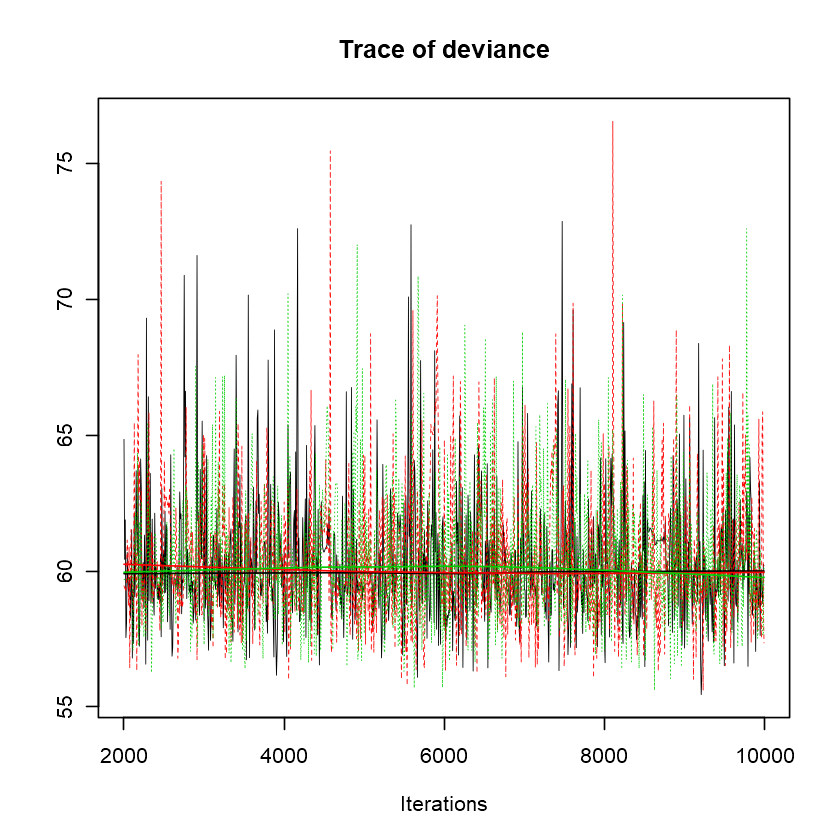

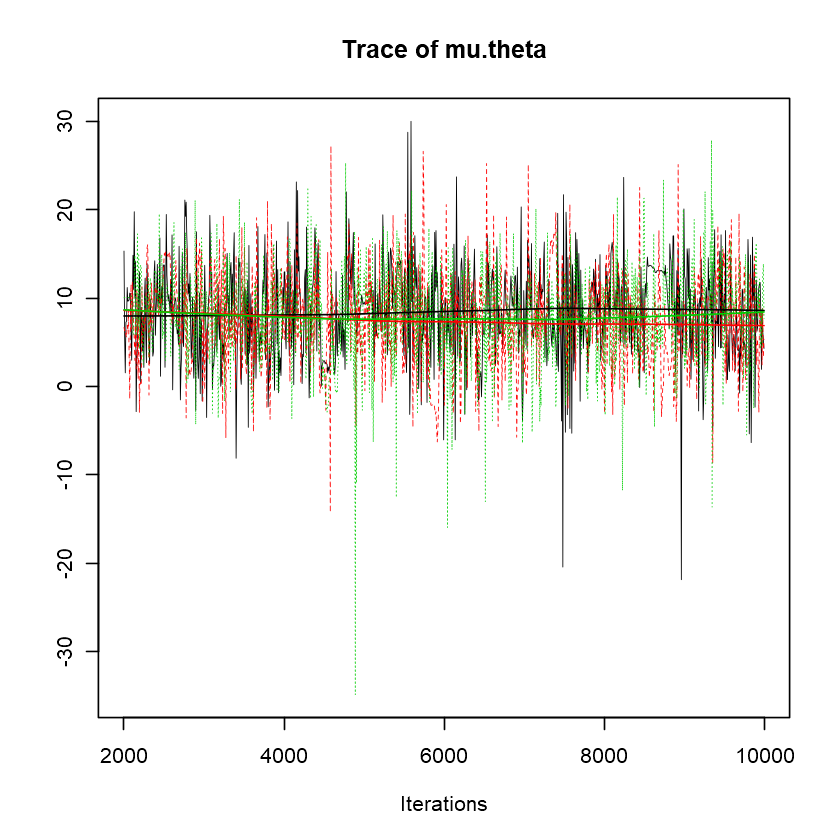

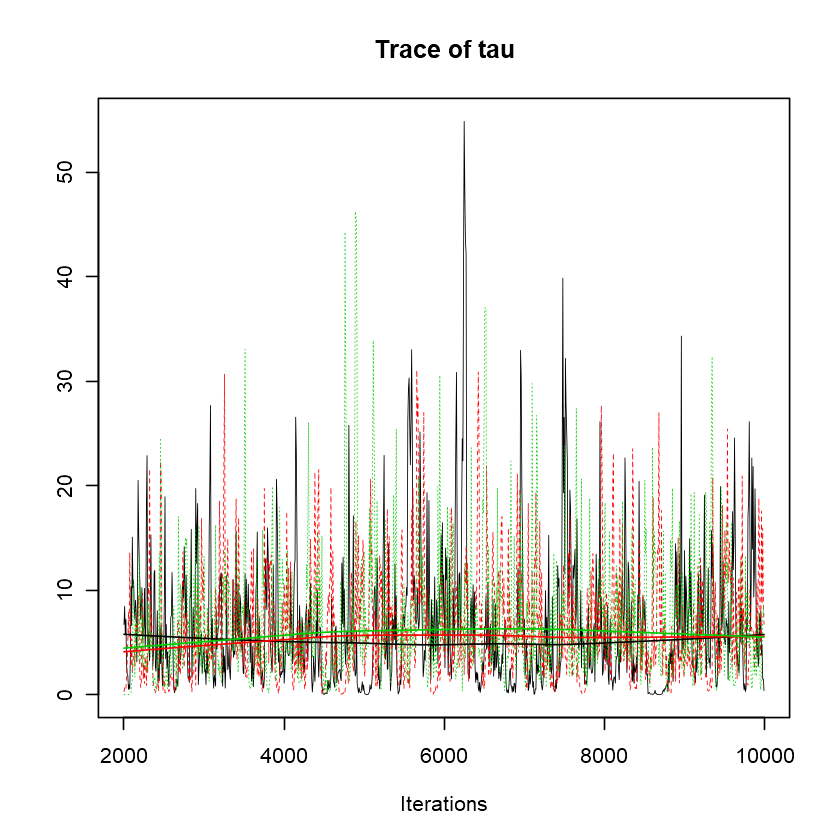

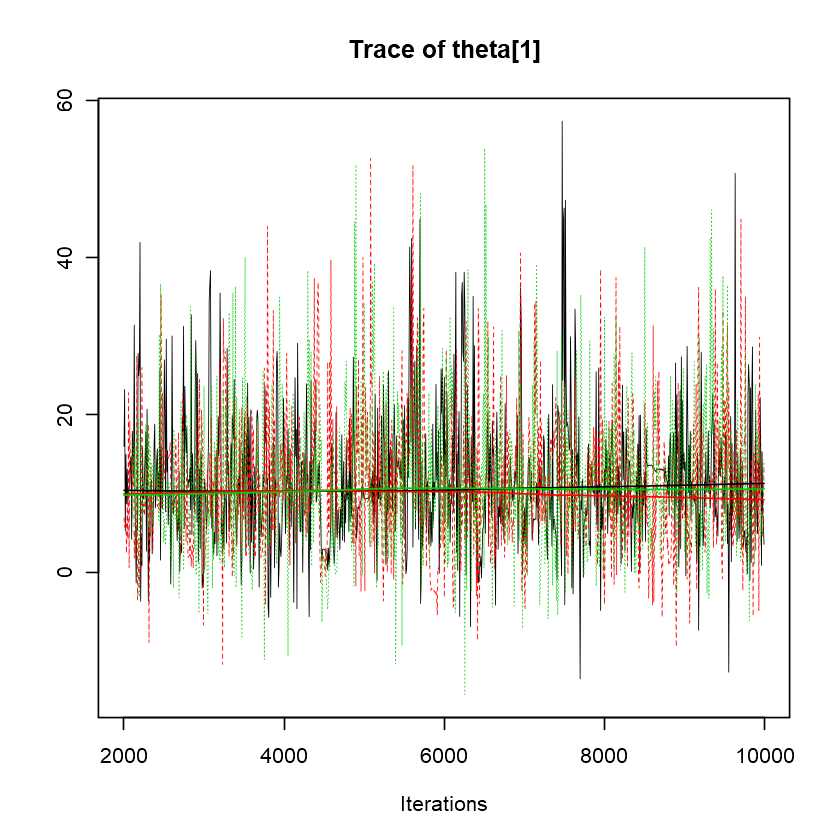

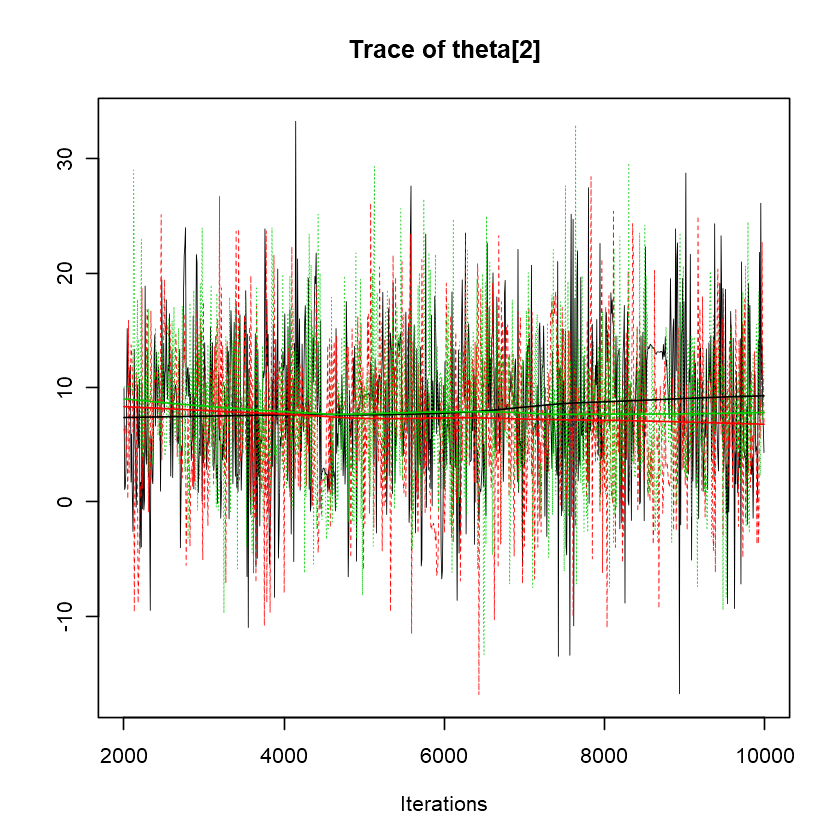

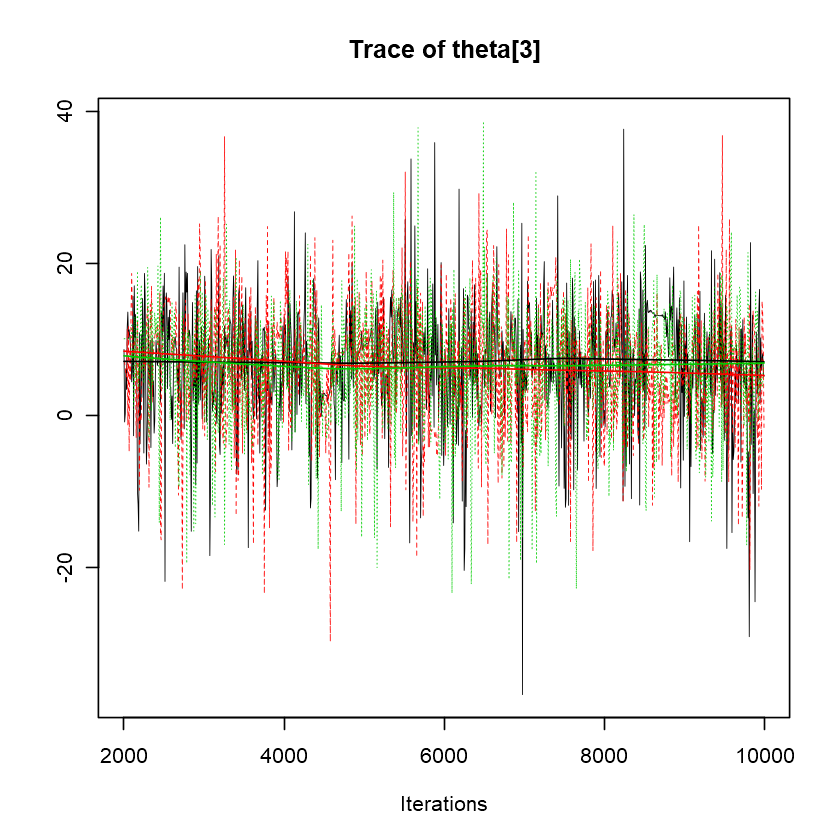

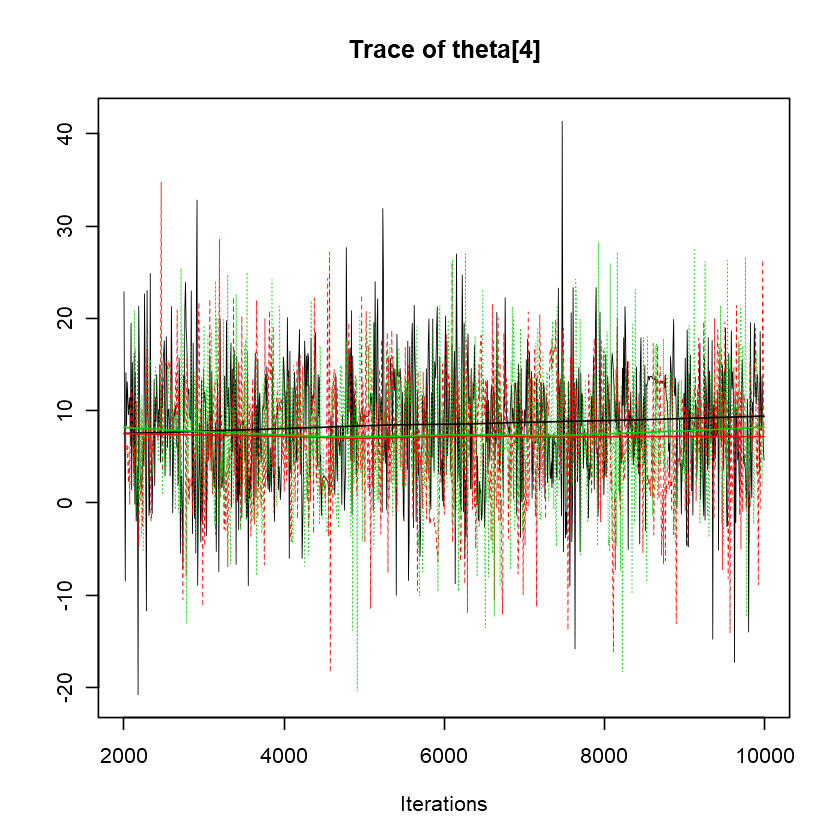

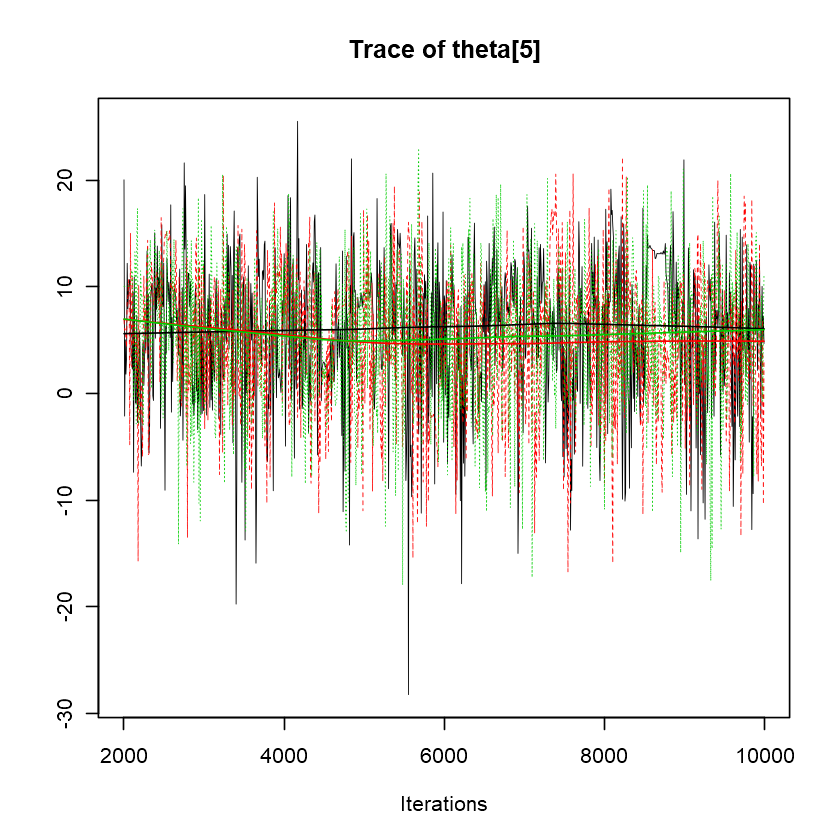

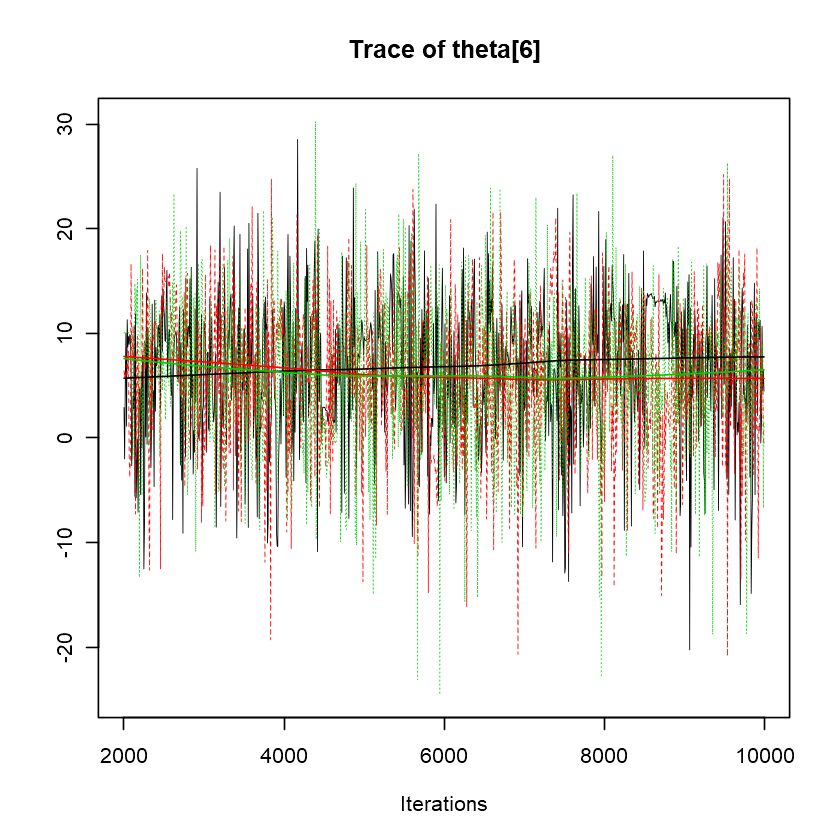

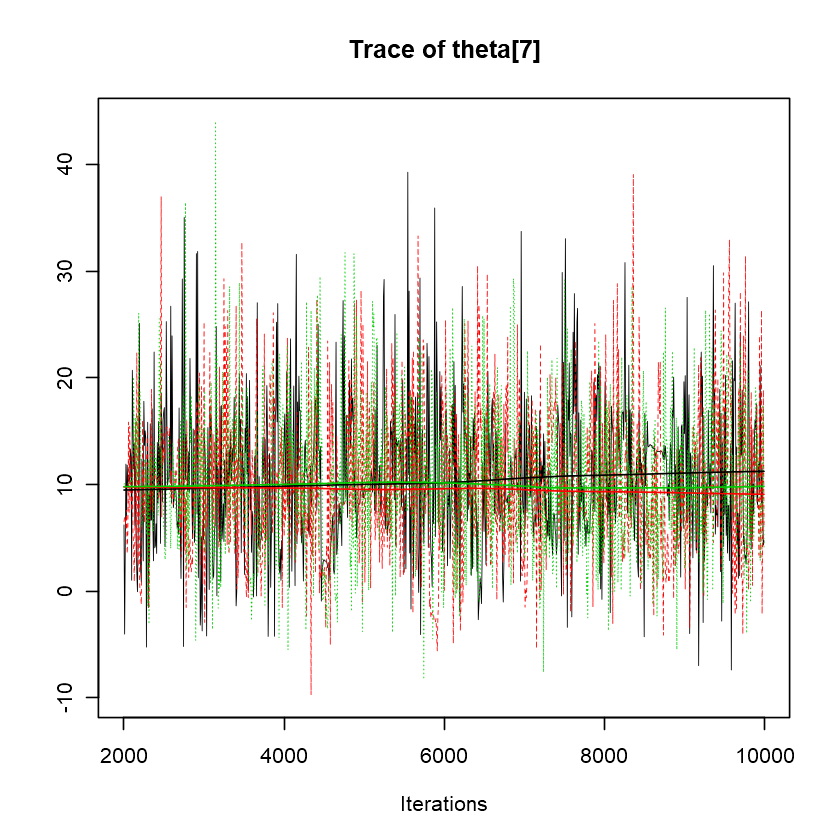

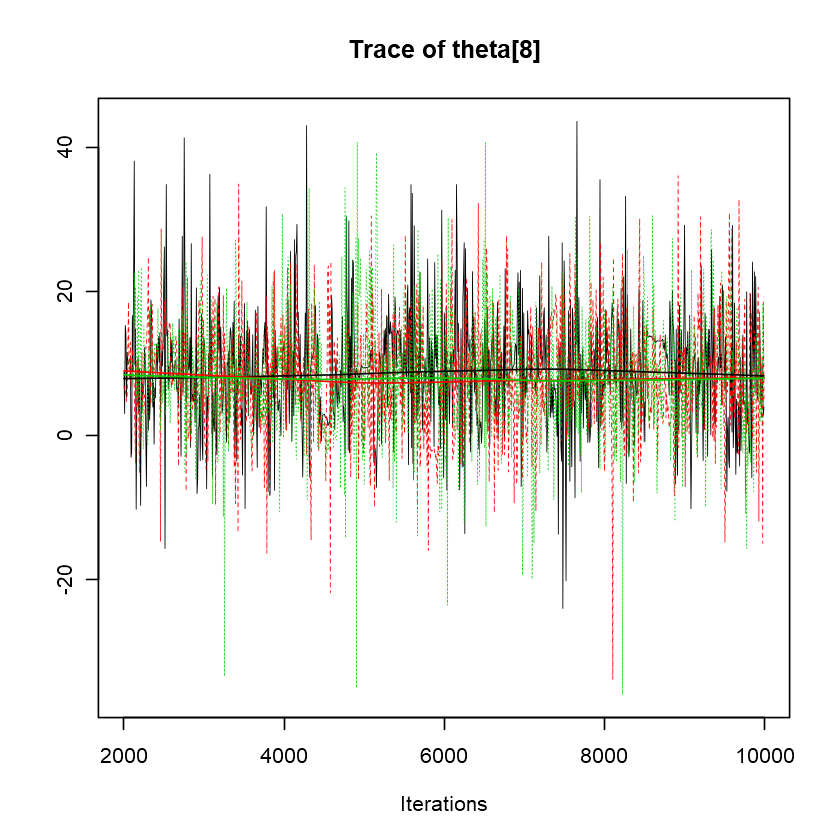

In [15]:
traceplot(schools.m1.mcmc,lwd=0.5)

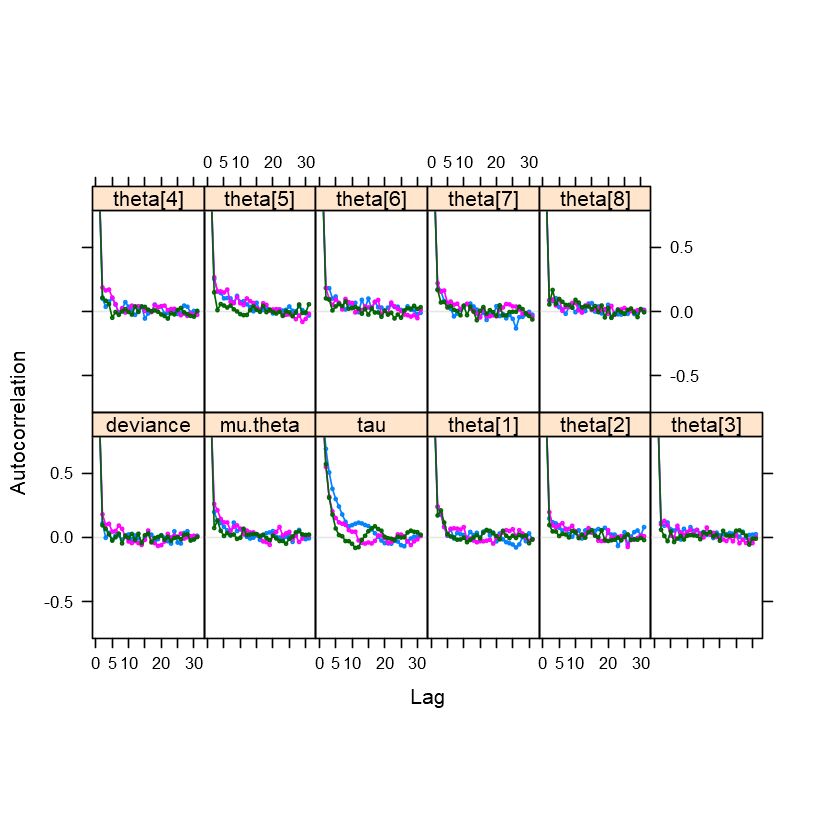

In [16]:
acfplot(schools.m1.mcmc,cex=0.2)

Loading required package: lattice


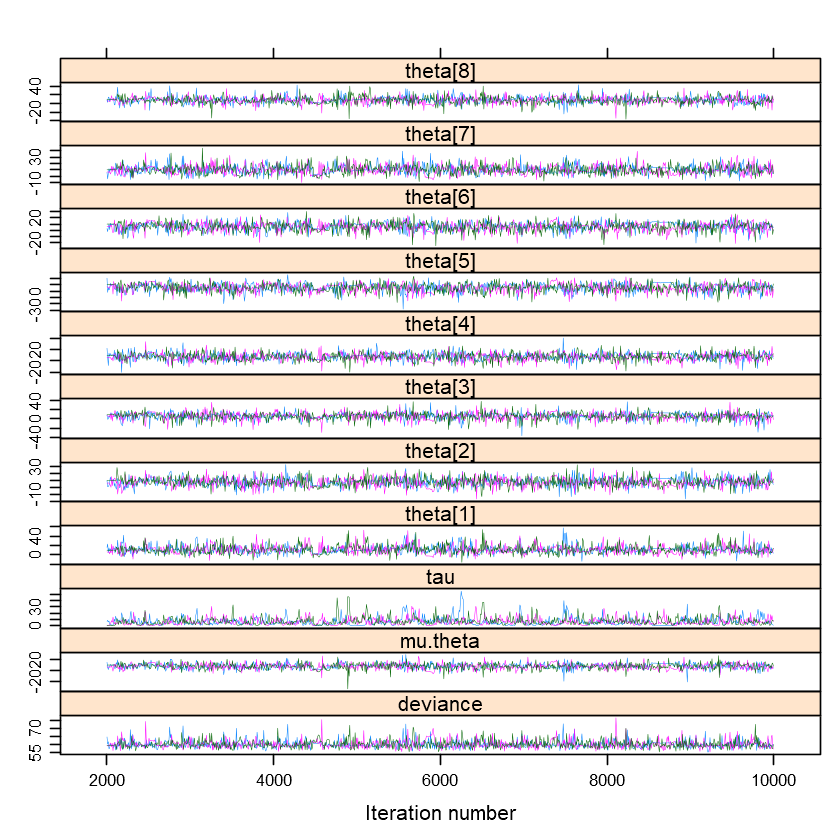

In [17]:
require(lattice)
xyplot(schools.m1.mcmc,lwd=0.3)

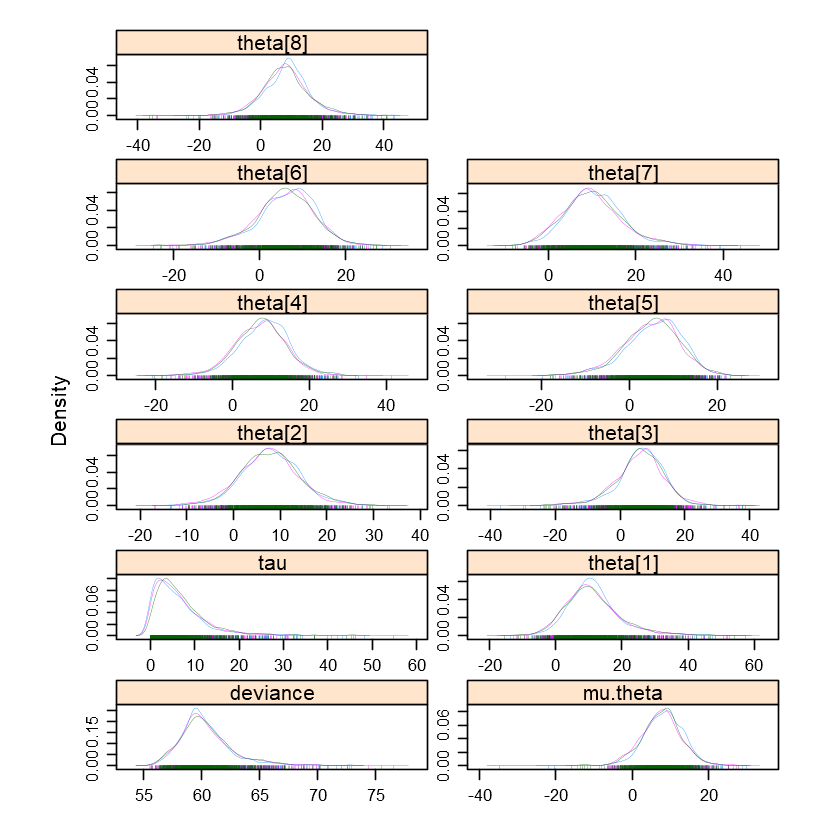

In [18]:
densityplot(schools.m1.mcmc,lwd=0.2)